<div style="background-color:LightBlue; text-align:center; padding:20px;">
    <h2 style="color:black; font-family: Verdana, sans-serif;"><strong>Reinforcement Learning Project - ViZ Doom</strong></h2>
    <p style="font-size: 14px; color: black; font-family: Verdana, sans-serif;"> 
        <table style="margin: auto; border-collapse: collapse; color: black;">
            <tr>
                <th style="border: 0;">Names</th>
                <th style="border: 0;">GitHub Username</th>
            </tr>
            <tr>
                <td style="border: 0;">Rogier Gernaat</td>
                <td style="border: 0;">RogierHHS</td>
            </tr>
            <tr>
                <td style="border: 0;">Daan Eising</td>
                <td style="border: 0;">DaanEising</td>
            </tr>
            <tr>
                <td style="border: 0;">Julia Boschman</td>
                <td style="border: 0;">JuliaBoschman</td>
            </tr>
            <tr>
                <td style="border: 0;">Jort dihhhoek</td>
                <td style="border: 0;">Homoboi-kankerboi</td>
            </tr>
        </table>
    </p></div>

<div style="display: flex; justify-content: center; align-items: center; margin-top: 10px;">
    <img src="Overige bestanden\Doomski.png" alt="Doomski.png" style="width: 1000px; height: auto;">
</div>


- ***Docent***: Vikram Radhakrishnan
- ***Datum***: 08-04-2025


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Inhoudsopgave </strong></h2>
</div>



1. [H1: Inleiding](#1.0)
    - [&sect;1.1: Imports](#1.1)
2. [H2: Use Case](#2.0)
    - [&sect;2.1: Kiezen van Use Case](#2.1)
    - [&sect;2.2: Probleemdefinitie](#2.2)
    - [&sect;2.3: Doelstelling](#2.3)
3. [H3: Ontwerp en Implementatie van het RL-model](#3.0)
    - [&sect;3.1: Ontwikkelen Baseline strategie](#3.1)
    - [&sect;3.2: Implementeren van een algoritme](#3.2)
    - [&sect;3.3: Experimenteer met hyperparameters](#3.3)
    - [&sect;3.4: Training](#3.4)
    - [&sect;3.5: Deep Q-Learning](#3.4)
4. [H4: Valideer en Vergelijk](#4.0)
    - [&sect;4.1: Vergelijken met minimaal één baseline](#4.1)
    - [&sect;4.2: Analiseren en Visualiseren van Resultaten](#4.2)
6. [H5: Beschrijf je werk (Rapport)](#5.0)
    - [&sect;6.1: Probleemstelling](#5.1)
    - [&sect;6.2: Methodologie](#5.2)
    - [&sect;6.3: Resultaten](#5.3)
    - [&sect;6.4: Reflectie](#5.4)
7. [H6: Literatuurlijst](#6.0)
8. [H7: Beoordelingscriteria](#7.0)



---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong>H1: Inleiding </strong></h2>
</div>

<a name='1.1'></a>
<h3>&sect;1.1: Imports</h3>

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Importeren van de library's</strong>
</div>



In [ ]:
#Importeren van de nodige libraries
import cv2
import random
import time
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import tensorflow as tf
from collections import deque
from skimage import transform

#Vizdoom
from vizdoom import *
from vizdoom import DoomGame, Mode

#imports uit .py bestanden
sys.path.append(os.path.abspath("SRC"))

from environment import VizDoomEnvironment
from baseline import random_baseline
from utils import collect_frames_with_actions, visualize_q_table
from utils import show_shoot_frames
from deep_qutils import stack_frames
from deep_qutils import preprocess_frame
from deep_qutils import create_environment
from agent import QLearningAgent
from training import train_q_learning
from deep_q_environment import DeepVizDoomEnvironment
from deep_q_model import DQNetwork, Memory
from deep_q_baseline import deep_qrandom_baseline

In [2]:
!pip install vizdoom

In [3]:
!cd github & git clone https://github.com/mwydmuch/ViZDoom.git

The system cannot find the path specified.
fatal: destination path 'ViZDoom' already exists and is not an empty directory.



---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong>H2: Use Case </strong></h2>
</div>



<a name='2.1'></a>
<h3>&sect;2.1: Kiezen van Use Case</h3>

### Gekozen omgeving

Voor deze opdracht is gekozen voor een omgeving uit de Gymnasium-documentatie, namelijk **ViZDoom**. ViZDoom is een visueel complexe en interactieve omgeving gebaseerd op de klassieke game Doom.  

In dit project starten we met het scenario `basic.cfg`, waarin een agent zich in een kamer bevindt en één vijand moet uitschakelen. De agent ontvangt **-1 reward** voor elke actie, en **+100 reward** bij het succesvol verslaan van de vijand.  

Later wordt dit uitgebreid naar uitdagendere scenario's zoals `deadly_corridor.cfg`, waarin meerdere tegenstanders en gevaren aanwezig zijn.

---

### Waarom reinforcement learning?

Reinforcement learning (RL) is bijzonder geschikt voor deze taak, om de volgende redenen:

- **De agent leert via interactie**  
  ViZDoom vereist dat de agent leert door trial-and-error, zonder vooraf bepaalde instructies. Acties zoals bewegen of schieten leiden tot beloningen, en het model leert welk gedrag effectief is.

- **Geen gelabelde data beschikbaar**  
  Anders dan bij supervised learning, zijn er geen juiste/onjuiste labels beschikbaar. Het doelgedrag moet ontdekt worden op basis van reward.

- **Strategisch gedrag nodig**  
  Bewegingen en acties moeten gecombineerd worden op basis van visuele input. Rule-based systemen schieten hier tekort, omdat de omgeving dynamisch is (zoals willekeurige spawnlocaties van vijanden).

- **RL past bij het probleemtype**  
  De ViZDoom-omgeving moedigt exploratie aan en beloont effectief gedrag. Dat is precies de reden waarom reinforcement learning hier goed bij past.

---

<a name='2.2'></a>
<h3>&sect;2.2: Probleemdefinitie</h3>

Reinforcement Learning (RL) heeft de afgelopen jaren veel vooruitgang laten zien bij het oplossen van problemen waarbij een computer (agent) moet leren door zelf dingen uit te proberen in een omgeving. Traditionele methodes, zoals supervised learning, zijn meestal minder geschikt voor situaties waarin de agent continu moet reageren op directe feedback en snel veranderende omstandigheden. Dit is vooral merkbaar in real-time spellen zoals VizDoom. In VizDoom moet een agent zelfstandig beslissingen nemen, reageren op onverwachte situaties, vijanden ontwijken of verslaan, en duidelijke doelen behalen in een dynamische spelomgeving.

Reinforcement Learning is bijzonder geschikt voor dynamische omgevingen zoals VizDoom omdat de agent actief leert door interactie met de omgeving en directe feedback krijgt via beloningen (rewards). Dit stelt de agent in staat zich continu aan te passen aan veranderingen in het spel. De voordelen van RL ten opzichte van supervised learning en niet-AI methoden in VizDoom zijn duidelijk. Supervised learning vereist vooraf gelabelde data en kan zich moeilijk aanpassen aan onverwachte situaties, terwijl RL juist leert van eigen ervaring en zich flexibel aanpast. Niet-AI methoden zijn vaak gebaseerd op vaste regels en zijn niet in staat om zelfstandig te leren of zich snel aan te passen aan nieuwe situaties, wat juist essentieel is in dynamische spellen zoals VizDoom.

Daarom willen we onderzoeken hoe een agent via RL effectief kan leren handelen in VizDoom.

#### Centrale probleemstelling:
- "Hoe kan een Reinforcement Learning-agent effectief leren opereren en goede resultaten behalen in de dynamische en uitdagende spelomgeving van VizDoom?"

<a name='2.2'></a>
<h3>&sect;2.3: Doelstelling</h3>

Het doel van deze opdracht is het ontwikkelen, implementeren en valideren van een Reinforcement Learning-agent die binnen de VizDoom-omgeving zelfstandig leert om optimale beslissingen te nemen en specifieke taken succesvol uit te voeren. De volgende subdoelstellingen zijn hierbij geformuleerd:

1. Onderzoek en analyse:
    - Bepaal waarom Reinforcement Learning bijzonder geschikt is voor het oplossen van problemen in dynamische omgevingen zoals VizDoom.
    - Analyseer de voordelen van RL ten opzichte van supervised learning en niet-AI methoden specifiek in de context van VizDoom.

2. Ontwerp en implementatie:
    - Ontwerp en implementeer een baseline-strategie (bijvoorbeeld random of een eenvoudige heuristiek) om prestaties te kunnen benchmarken.
    - Ontwikkel zelfstandig een RL-algoritme (zoals Q-learning of Sarsa) met minimale afhankelijkheid van bestaande RL-packages.
    - Optimaliseer het geïmplementeerde RL-algoritme door systematisch te experimenteren met verschillende hyperparameters (bijvoorbeeld exploration-exploitation balans).

3. Evaluatie en validatie:
    - Vergelijk de prestaties van het ontwikkelde RL-model met de baseline-strategie door middel van heldere en reproduceerbare experimenten.
    - Analyseer en visualiseer gedetailleerd de prestaties van het RL-model met behulp van reward-curves en andere relevante prestatie-indicatoren.

Door deze doelstellingen uit te voeren, krijgen we beter inzicht in hoe Reinforcement Learning gebruikt kan worden in complexe en dynamische spelomgevingen zoals VizDoom.


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H3: Ontwerp en Implementatie </strong></h2>
</div>

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Testen met basic.wad scenario</strong>
</div>

In deze sectie testen we of ViZDoom goed functioneert door het `basic.wad` scenario op te starten. We laten een eenvoudige agent willekeurige acties uitvoeren, zodat we kunnen controleren of de installatie werkt en hoe de omgeving reageert.

---

###  Waar komen de bestanden vandaan?

Wanneer je ViZDoom installeert via pip en de repository op github, worden er automatisch enkele **standaard scenario’s** meegeleverd. Deze scenario's bevatten `.cfg` (configuratie) bestanden en `.wad` (level/map) bestanden, zoals:

- `basic.cfg`: bevat instellingen zoals de tijdslimiet van het spel, welke acties beschikbaar zijn, hoe rewards worden toegekend, enz.
- `basic.wad`: dit is de daadwerkelijke map/omgeving waarin het spel zich afspeelt — in dit geval één kamer met een vijand.

Zorg dat je `basic.cfg` pad goed staat in je project. Meestal zitten deze bestanden in de `ViZDoom/scenarios/` map.

---

###  Wat doet deze test?

De test start het Basic-scenario, voert een willekeurige actie uit in elk timestep, en toont de reward die de agent ontvangt. Aan het einde printen we de totale beloning.

De code doorloopt dus een **volledige episode** van het spel, van begin tot eind, zonder dat de agent slimme keuzes maakt. Het is puur bedoeld als functionele test.

---

###  Wat zijn actions?

De mogelijke acties in het Basic-scenario zijn beperkt tot:

- `LEFT` (beweeg naar links)
- `RIGHT` (beweeg naar rechts)
- `ATTACK` (schiet)

In de code worden deze acties als lijsten geschreven:

```python
[1, 0, 0]  # alleen links
[0, 1, 0]  # alleen rechts
[0, 0, 1]  # alleen schieten


In [4]:
# Setup Doom-game
game = DoomGame()
game.load_config("ViZDoom/scenarios/basic.cfg")  
game.set_window_visible(True)  # Maakt het spel zichtbaar
game.init()

# Definieer toegestane acties in basic.wad: [left, right, shoot]
actions = [[1, 0, 0],  # Left
           [0, 1, 0],  # Right
           [0, 0, 1]]  # Shoot

# Speel één episode met random acties
print("Episode gestart...")
game.new_episode()

while not game.is_episode_finished():
    state = game.get_state()
    reward = game.make_action(random.choice(actions))
    print("Reward:", reward)
    time.sleep(0)  # Vertraagt het spel om het beter te kunnen volgen

print("Totale score:", game.get_total_reward())
game.close()


Episode gestart...
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -6.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -6.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -6.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -6.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward: -6.0
Reward: -1.0
Reward: -1.0
Reward: -1.0
Reward

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Observaties</strong>
</div>

Wat je kunt zien tijdens het uitvoeren van een episode met willekeurige acties, is dat de agent na bijna elke actie een reward van **-1.0** ontvangt. Dit betekent dat het ViZDoom-scenario zo is ingericht dat elke actie (zoals bewegen of schieten) een kleine straf oplevert. Op deze manier wordt de agent aangemoedigd om **doelgericht** te handelen, in plaats van doelloos rond te bewegen of continu te schieten.

Pas op het moment dat de agent de vijand raakt (door succesvol te schieten), krijgt hij een grotere beloning van bijvoorbeeld **+100.0**. Dit verschil tussen kleine negatieve en grote positieve rewards is essentieel in reinforcement learning: het helpt de agent om te leren **wat wel en niet effectief is**.

Tijdens de test zie je:

- De agent beweegt of schiet → reward: -1.0
- Als de agent de vijand raakt (per toeval) → reward: +100.0
- Zodra de vijand is verslagen of de tijd op is → de episode eindigt
- De totale score wordt weergegeven met `get_total_reward()` — dit is de som van alle beloningen die de agent in die episode heeft ontvangen

Omdat deze agent puur willekeurige acties uitvoert, is zijn gedrag ongericht. Je zult merken dat de **totale score per episode erg varieert**, en meestal vrij laag is. Dit bevestigt dat de random agent geen strategie gebruikt


<div style="background-color:white; color:black; padding: 10px;">
    <strong>Opzetten van een zelfgemaakte ViZDoom-omgeving</strong>
</div>

In deze sectie bouwen we onze eigen environment class voor ViZDoom. Deze omgeving vormt een tussenlaag tussen onze reinforcement learning-agent en het spel. We maken een klasse aan met methodes zoals `reset()`, `step()`, `render()` en `close()` — zodat onze agent op een gestructureerde manier met de gameomgeving kan communiceren.

---

###  Waarom maken we een eigen RL-omgeving?

In reinforcement learning werkt een agent altijd in interactie met een **omgeving**. Deze omgeving moet de agent toestaan om:

- een actie te nemen,
- feedback (reward) te ontvangen,
- en een nieuwe toestand (state) te observeren.

Door een eigen omgeving te programmeren, creëren we een **duidelijke structuur** die makkelijk herbruikbaar is. Dit maakt het eenvoudiger om:

- onze eigen agent (zoals een Q-learning agent) te bouwen,
- de training te herhalen over meerdere episodes,
- en eventueel later andere scenario’s te integreren zonder de logica te herschrijven.

Onze omgeving is **niet gebaseerd op kant-en-klare pakketten**, maar volledig handmatig geprogrammeerd. Hierdoor blijft het project binnen de richtlijnen van de opdracht.

---

###  Wat zit er in onze omgeving?

Onze class bevat onder andere:

- `__init__()`: start de game, zet de actie-ruimte en observation-space op, en bepaalt of het spel gerenderd wordt.
- `step(action)`: voert een actie uit, geeft de reward terug, en retourneert de nieuwe toestand.
- `reset()`: start een nieuwe episode.
- `close()`: sluit de game netjes af.
- `grayscale()`: converteert het raw gamebeeld naar zwart-wit en schaalt het terug naar een eenvoudiger formaat, zodat het minder geheugen/intensiteit vereist.

---

###  Waarom is dit nuttig voor ons project?

Deze aanpak zorgt ervoor dat onze agent niet hoeft te weten **hoe ViZDoom precies werkt**. Alles wat de agent hoeft te doen, is `env.step(action)` en `env.reset()` gebruiken — en dat maakt het trainen van een RL-model overzichtelijker.

Bovendien kunnen we deze omgeving makkelijk hergebruiken voor verschillende algoritmes (zoals Sarsa of Deep Q-Learning), zonder de interne werking telkens opnieuw te moeten implementeren.

Tot slot: door **zelf de omgeving te bouwen**, tonen we aan dat we **begrijpen hoe de interface tussen agent en omgeving werkt** — en dat is een belangrijk leerdoel van deze opdracht.


<div style="background-color:white; color:black; padding: 10px;">
    <strong>Testen van de environment</strong>
</div>

In [5]:
env = VizDoomEnvironment(render = True, scenario = "basic.cfg", use_grayscale=False) #Start de environment


In [6]:
# Correcte tuple-unpacking
state, _ = env.reset()

# Nu werkt het wél:
print("State shape:", state.shape)


State shape: (3, 100, 160)


<div style="background-color:white; color:black; padding: 10px;">
    <strong>Observatie van een enkele stap in de omgeving</strong>
</div>

In deze observatie bekijken we wat er gebeurt wanneer we handmatig een actie uitvoeren binnen onze zelfgemaakte ViZDoom-omgeving. We gebruiken hiervoor de functie `env.step(2)`. De actie `2` staat in onze omgeving gelijk aan de actie **schieten** (`[0, 0, 1]`). 

De functie `step()` geeft vier waarden terug: de nieuwe state (observatie), de beloning, een boolean of de episode klaar is, en extra informatie over de toestand van het spel in dit geval de hoeveelheid ammonitie van de karakter. De output ziet er bijvoorbeeld als volgt uit:

```python
(array([[[...]]], shape=(100, 160, 1), dtype=uint8),
 -1.0,
 False,
 array([50.]))


In [7]:
#Hier kunnen we handmatig een actie invoeren en de resultaten bekijken
env.step(2)

(array([[[55, 50, 59, ..., 57, 57, 66],
         [68, 65, 65, ..., 56, 67, 72],
         [49, 79, 66, ..., 79, 51, 29],
         ...,
         [75, 63, 62, ..., 44, 71, 60],
         [15, 48, 47, ..., 49, 69, 47],
         [22, 14, 26, ..., 57, 37, 39]],
 
        [[55, 50, 59, ..., 57, 57, 66],
         [68, 65, 65, ..., 56, 67, 72],
         [49, 79, 66, ..., 79, 51, 29],
         ...,
         [75, 63, 62, ..., 44, 71, 60],
         [15, 48, 47, ..., 49, 69, 47],
         [22, 14, 26, ..., 57, 37, 39]],
 
        [[55, 50, 59, ..., 57, 57, 66],
         [68, 65, 65, ..., 56, 67, 72],
         [49, 79, 66, ..., 79, 51, 29],
         ...,
         [75, 63, 62, ..., 44, 71, 60],
         [15, 48, 47, ..., 49, 69, 47],
         [22, 14, 26, ..., 57, 37, 39]]], dtype=uint8),
 -1.0,
 False,
 array([50.]),
 None)

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Visualisatie van een gameframe</strong>
</div>

De afbeelding hierbeneden is een voorbeeld van een gameframe zoals de agent die op dit moment ontvangt binnen een episode. Je kunt hier goed zien dat de game correct geladen is: het wapen van de speler is zichtbaar in het midden, en links zien we de vijand die geraakt moet worden.

Dit soort visualisaties zijn handig om te controleren of de environment goed werkt en of de observaties die de agent binnenkrijgt logisch zijn. Als je hier bijvoorbeeld een zwart scherm of fout beeld zou zien, weet je dat er iets mis is met de state-afhandeling of het `.step()`-proces.

Het beeld is automatisch **omgezet naar grijswaarden** en **verkleind naar 160×100 pixels**. Dat hebben we bewust gedaan om het **simpeler en efficiënter** te maken voor de reinforcement learning agent. Kleuren en hoge resolutie zijn niet nodig voor dit scenario — het gaat er vooral om dat de agent de posities van objecten herkent en leert hoe hij moet reageren.

Deze versimpeling helpt bij het versnellen van het leerproces en het verminderen van het geheugenverbruik tijdens training.

---
We hebben de environment wel zo opgezet dat de grayscale optioneel is zodat we later als we nog willen spelen met scenario's waar het systeem juist wel kleur ziet kan dat ook nog kan

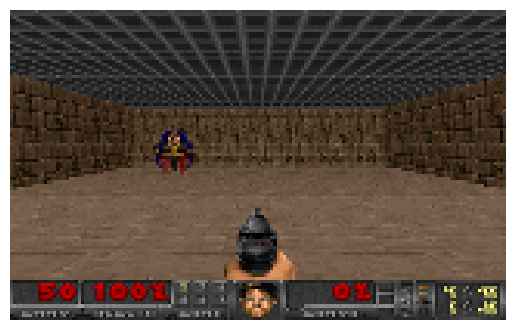

In [8]:
def show_state(state):
    if state.ndim == 3 and state.shape[-1] == 1:
        # Grayscale image
        plt.imshow(state.squeeze(), cmap='gray')
    elif state.ndim == 3 and state.shape[0] == 3:
        # Color image, channels first → convert to channels last
        plt.imshow(np.moveaxis(state, 0, -1))
    else:
        raise ValueError(f"Onverwachte shape voor image: {state.shape}")
    plt.axis('off')
    plt.show()

show_state(state) #Laat de image zien

env.close() #Sluit de environment af

<a name='3.1'></a>
<h3>&sect;3.1: Ontwikkelen Baseline Stategie</h3>

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Baseline strategie "Random"</strong>
</div>
De baseline strategie die we hebben gekozen voor de basic.wad is random. Dit is gekozen omdat wij denken dat dit de meest stabiele 

In [9]:
env = VizDoomEnvironment(render = True) #Start de environment
random_baseline(env, 10) #Speel 10 episodes met random acties
env.close() #Sluit de environment

Random baseline gestart...
Episode 1: totale reward = 91.0
Episode 2: totale reward = 93.0
Episode 3: totale reward = 93.0
Episode 4: totale reward = 44.0
Episode 5: totale reward = 95.0
Episode 6: totale reward = 40.0
Episode 7: totale reward = 20.0
Episode 8: totale reward = 52.0
Episode 9: totale reward = 93.0
Episode 10: totale reward = 2.0

Gemiddelde reward over 10 episodes: 62.30


<div style="background-color:white; color:black; padding: 10px;">
    <strong>Observaties</strong>
</div>

Tijdens het draaien van de random baseline met `render=True` valt op dat het ViZDoom-spel **wordt weergegeven in kleur en op volledige resolutie**. Dit kan verwarrend lijken, omdat we verwachten dat de agent met versimpelde beelden werkt.

De verklaring hiervoor is dat het **ViZDoom-venster puur bedoeld is voor debugging en observatie door de gebruiker**. Wat we op het scherm zien, is het originele spelbeeld — compleet met kleuren, HUD en hoge resolutie.

De agent zelf werkt echter met een volledig andere input. In onze `VizDoomEnvironment` hebben we een `grayscale()` functie gedefinieerd die het originele spelbeeld omzet naar:

- **grijswaarden** (geen kleurinformatie)
- **verkleind formaat** van 160×100 pixels
- **enkel relevant visueel detail**

Dit verwerkte beeld is wat de agent daadwerkelijk ontvangt als “state”, en dus ook gebruikt bij het nemen van beslissingen. Door deze versimpeling wordt het leerproces efficiënter: de agent hoeft zich niet bezig te houden met overbodige informatie zoals kleur of interface-elementen, maar kan zich focussen op belangrijke visuele kenmerken zoals de positie van vijanden of het richten van zijn wapen.

hier beneden dan ook dus 

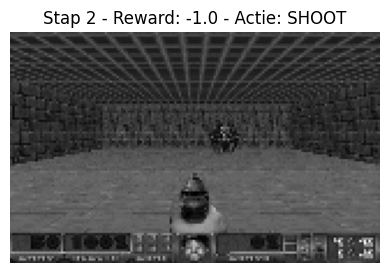

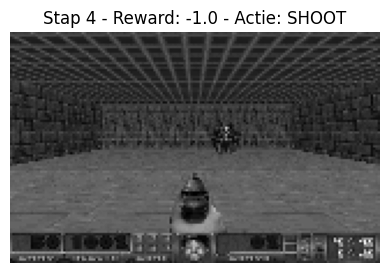

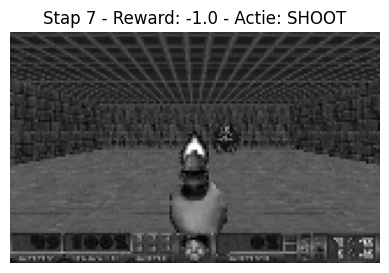

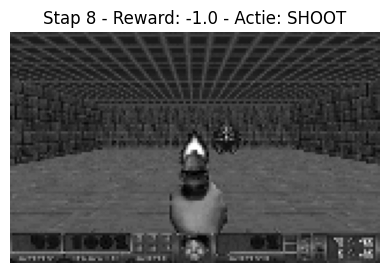

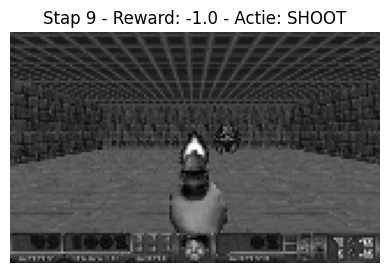

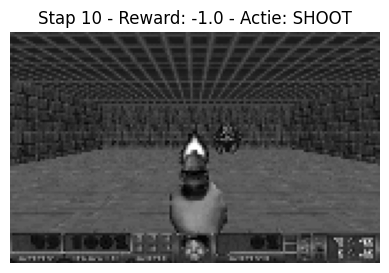

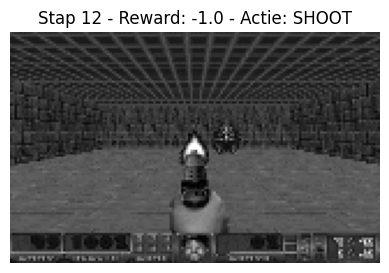

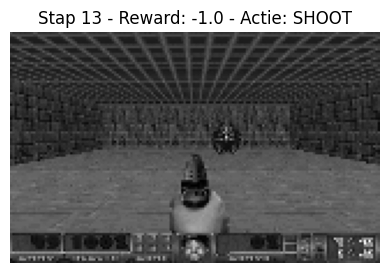

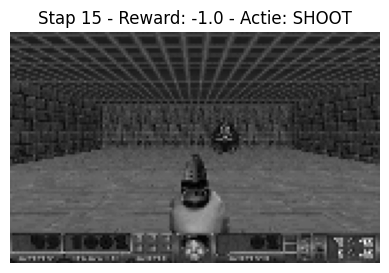

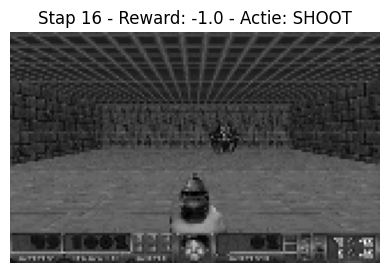

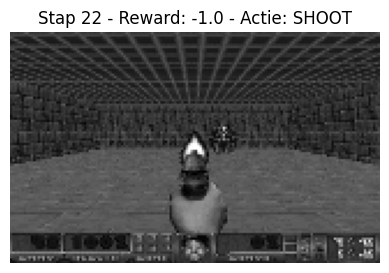

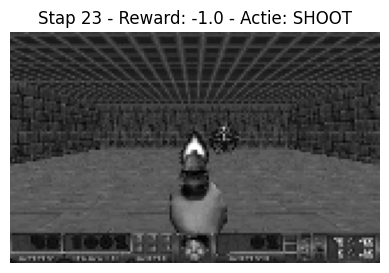

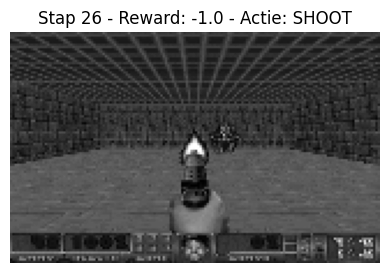

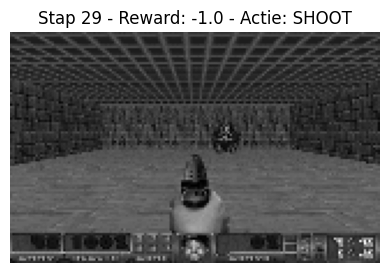

In [10]:
# Speel een episode met random acties en verzamel frames
env = VizDoomEnvironment(render=True)
frames = collect_frames_with_actions(env, max_steps=30)
env.close()

# Toon de verzamelde frames met een actie één voor één
show_shoot_frames(frames, target_action=2)

<a name='3.1'></a>
<h3>&sect;3.2: Implementeren van een Algoritme</h3>

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Wat is Q-learning?</strong>
</div>

Q-learning is een **value-based reinforcement learning algoritme** waarmee een agent leert welke acties hij het best kan nemen in bepaalde situaties om een zo hoog mogelijke beloning (reward) te behalen. De kern van Q-learning is het bijhouden van een zogeheten **Q-table**: een tabel waarin per situatie (state) en actie (action) wordt opgeslagen hoe “goed” die actie op dat moment is.

Bij elke stap in een episode leert de agent door middel van **trial-and-error** of zijn actie nuttig was, en past hij zijn Q-waarden hierop aan. Na voldoende episodes leert de agent welke acties hem dichter bij zijn doel brengen (bijvoorbeeld het verslaan van een vijand in ViZDoom).

---

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Hoe werkt Q-learning bij ViZDoom?</strong>
</div>

In tegenstelling tot de simpele, discrete omgevingen die we tijdens de les zagen (zoals FrozenLake), gebruikt ViZDoom **visuele input** als observatie (grijswaarden-afbeeldingen). Daardoor moeten we enkele slimme aanpassingen doen:

- De **observaties** (beelden) worden via de `grayscale()` functie verkleind en versimpeld tot zwart-wit beelden van 160×100 pixels.
- Omdat deze beelden niet eenvoudig te gebruiken zijn als sleutel in een Q-table, zetten we ze om naar een **hash**: een versimpelde representatie van het beeld (bijv. door pixels te flattenen).
- We gebruiken een **`defaultdict`** in plaats van een vaste tabel, omdat we niet weten hoeveel unieke states er precies zijn.
- De agent kiest een actie op basis van een **ε-greedy policy**: hij kiest soms willekeurig (exploratie) en soms de beste actie volgens zijn Q-table (exploitatie).
- Na elke stap **update de agent zijn Q-waarde** volgens de Q-learning-formule, met behulp van de beloning en de verwachte toekomstige beloning.

---

###  Belangrijke parameters in Q-learning

| Parameter       | Betekenis |
|-----------------|-----------|
| `alpha` (lr)    | Leer-snelheid — hoeveel past de agent zijn Q aan per stap |
| `gamma`         | Discount factor — hoe belangrijk zijn toekomstige rewards |
| `epsilon`       | Exploratiegraad — hoe vaak kiest de agent een willekeurige actie |
| `epsilon_decay` | Hoe snel de exploratie afneemt over tijd |

---

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Check of de GPU word gebruikt</strong>
</div>

In [11]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0),
          "| CUDA", torch.version.cuda,
          "| PyTorch", torch.__version__)

CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Ti | CUDA 11.8 | PyTorch 2.3.1+cu118


<a name='3.4'></a>
<h3>&sect;3.4: Training</h3>


---

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Eerste test ronde, zonder grayscale </strong>
</div>

We zijn begonnen met het testen zonder gebruik van grayscale, om een eerste indruk te krijgen van de prestaties van de agent in deze opstelling. Het is hier vooral duidelijk dat de uitvoering erg snel is wat er voor zorgt dat we veel episodes kunnen runnen.

Hoewel we in totaal meerdere testuitvoeringen hebben gedaan, zijn niet alle runs opgeslagen. In het onderdeel Evaluatie van de modellen geven we wel enkele representatieve voorbeelden weer.

De behaalde scores zijn over het algemeen matig, en de agent lijkt weinig tot geen vooruitgang te boeken tijdens het trainen. Een waarschijnlijke verklaring hiervoor is dat in het basic.cfg scenario de tegenstander bij elke episode op een willekeurige locatie spawnt. Voor een relatief eenvoudig algoritme zoals Q-learning, dat sterk afhankelijk is van herhaalbare patronen, maakt deze randomisatie het bijzonder lastig om effectief te leren. Omdat het model geen manier heeft om de locatie van de tegenstander te voorspellen, blijft het steken in ineffectieve gedragingen.

In [12]:
#  Start de environment mét of zonder kleurherkenning
env = VizDoomEnvironment(
    render=True,
    scenario="basic.cfg",
    actions=None,                  
    use_grayscale=True,
    use_enemy_color_detection=True       
)

#  Train het Q-learning model
agent, rewards = train_q_learning(
    env,
    episodes=20,                       
    learning_rate=0.005,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.99,
    epsilon_min=0.05,
    frame_skip=4,
    policy="softmax"
)

#  Sluit de environment
env.close()


Episode 1 - Reward: -370.00 - Epsilon: 0.471
Episode 2 - Reward: -375.00 - Epsilon: 0.221
Episode 3 - Reward: 87.00 - Epsilon: 0.213
Episode 4 - Reward: 95.00 - Epsilon: 0.208
Episode 5 - Reward: 95.00 - Epsilon: 0.204
Episode 6 - Reward: 95.00 - Epsilon: 0.200
Episode 7 - Reward: -21.00 - Epsilon: 0.154
Episode 8 - Reward: 91.00 - Epsilon: 0.150
Episode 9 - Reward: -375.00 - Epsilon: 0.070
Episode 10 - Reward: -380.00 - Epsilon: 0.050
Episode 11 - Reward: -370.00 - Epsilon: 0.050
Episode 12 - Reward: 91.00 - Epsilon: 0.050
Episode 13 - Reward: -200.00 - Epsilon: 0.050
Episode 14 - Reward: -365.00 - Epsilon: 0.050
Episode 15 - Reward: 66.00 - Epsilon: 0.050
Episode 16 - Reward: 0.00 - Epsilon: 0.050
Episode 17 - Reward: 91.00 - Epsilon: 0.050
Episode 18 - Reward: 95.00 - Epsilon: 0.050
Episode 19 - Reward: 91.00 - Epsilon: 0.050
Episode 20 - Reward: 95.00 - Epsilon: 0.050



---
<div style="background-color:white; color:black; padding: 10px;">
    <strong>Visualiseren van de Q waardes</strong>
</div>

Aantal geleerde states: 329


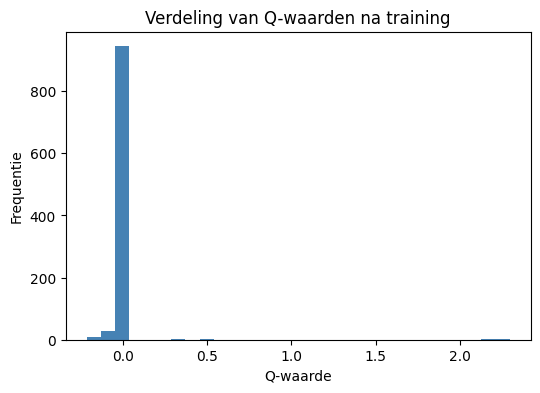

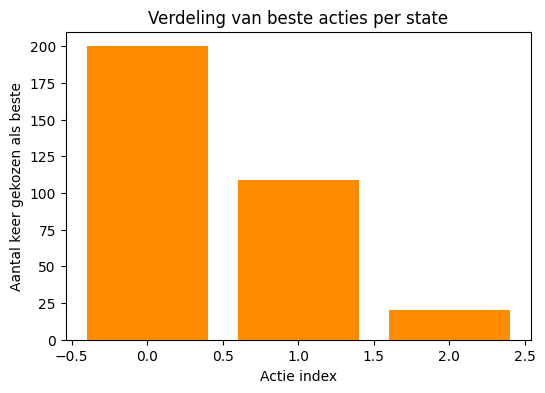

Geen voorbeeldstate meegegeven → sla individuele Q-plot over.

Top 5 meest overtuigende Q-beslissingen (grootste verschil tussen beste actie en gemiddeld):
Top 1:
  Q-waarden: [0.   0.   2.29]
  Beste actie: 2 met vertrouwen 1.53

Top 2:
  Q-waarden: [ 0.   -0.02  2.18]
  Beste actie: 2 met vertrouwen 1.46

Top 3:
  Q-waarden: [-0.04  0.5  -0.04]
  Beste actie: 1 met vertrouwen 0.36

Top 4:
  Q-waarden: [0.  0.5 0. ]
  Beste actie: 1 met vertrouwen 0.33

Top 5:
  Q-waarden: [0.  0.  0.5]
  Beste actie: 2 met vertrouwen 0.33



In [13]:
visualize_q_table(agent)

bijhouden van gedrag zodat we kunnen documenteren wat hij doet:

- nadat hij 1 strategie ziet die goed werkt, dus de actie naar links lopen en schieten, denkt de agent dat dit optimaal is en blijft hij vasthangen
- wanneer ik de epsilon_min verhoog > lijkt het  de linker muur minder aan te houden
- het model lijkt niet heel goed te kunnen leren aan de hand van de Q-table waardes sinds de tegenstander random spawnt 

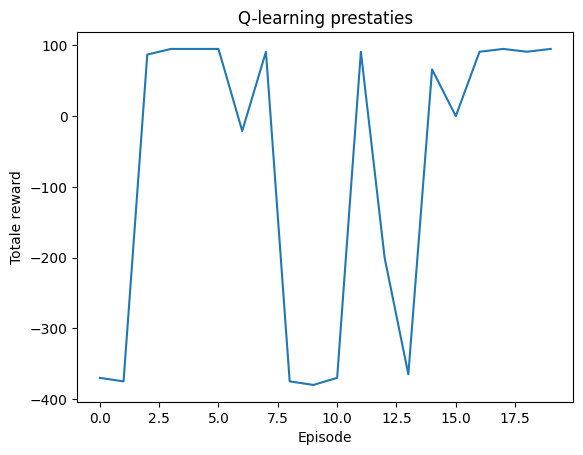

In [14]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Totale reward")
plt.title("Q-learning prestaties")
plt.show()



---
<div style="background-color:white; color:black; padding: 10px;">
    <strong>Het model proberen kleuren te laten herkennen en lokaliseren</strong>
</div>

In dit stuk hebben we geprobeerd om de agent te ondersteunen bij het grootste probleem waar hij tijdens het trainen tegenaan loopt: het vinden van de tegenstander. Q-learning is heel sterk in het herkennen van patronen, maar in het `basic.cfg` scenario spawnt de tegenstander steeds op een andere plek. Daardoor lukt het de agent niet goed om echt te leren *waar* hij moet zoeken, en blijft het erg wisselvallig of de agent daadwerkelijk iets leert.

Als oplossing hebben we geprobeerd om de tegenstander visueel te laten herkennen op basis van kleur. We hebben een screenshot genomen van een situatie waarin de tegenstander duidelijk in beeld is, en met een online tool opgezocht welke BGR-kleuren in de sprite zitten. Deze kleuren hebben we vervolgens hardcoded meegegeven aan de agent, in de hoop dat hij op die manier kan herkennen of (en waar) de tegenstander in beeld is.

De herkenning zelf werkt via onderstaande code:

```python
def detect_enemy_color(self, frame):
    # Specifieke spritekleuren van de tegenstander (BGR volgorde)
    enemy_colors_bgr = [
        (179, 0, 0),
        (33, 0, 1),
        (63, 63, 167),
        (0, 1, 71),
        (0, 255, 255),
        (44, 142, 186),
        (7, 15, 23),
        (29, 29, 114),
        (107, 155, 231),
        (143, 167, 191)
    ]
    return self.detect_enemy_position(frame, enemy_colors_bgr)

def detect_enemy_position(self, frame, color_list, tolerance=30):
    img = np.moveaxis(frame, 0, -1)  # (C, H, W) → (H, W, C)
    mask_total = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    for bgr in color_list:
        lower = np.array([max(0, c - tolerance) for c in bgr], dtype=np.uint8)
        upper = np.array([min(255, c + tolerance) for c in bgr], dtype=np.uint8)
        mask = cv2.inRange(img, lower, upper)
        mask_total = cv2.bitwise_or(mask_total, mask)

    if cv2.countNonZero(mask_total) > 150:
        contours, _ = cv2.findContours(mask_total, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            x, _, w, _ = cv2.boundingRect(largest)
            center_x = x + w // 2
            width = img.shape[1]

            if center_x < width / 3:
                return "left"
            elif center_x > 2 * width / 3:
                return "right"
            else:
                return "center"
    return None
```

Wat doet deze code precies?

- De functie `detect_enemy_color()` geeft een lijst van specifieke BGR-kleuren mee die voorkomen in de sprite van de tegenstander.
- In `detect_enemy_position()` wordt gecontroleerd of deze kleuren voorkomen in het beeld (`frame`) van de game.
- Eerst wordt het beeldformaat omgezet van `(C, H, W)` naar `(H, W, C)`, zodat het compatibel is met OpenCV.
- Voor elke kleur wordt een binair masker gemaakt dat pixels selecteert die binnen een bepaalde marge (`tolerance`) vallen.
- Alle individuele maskers worden gecombineerd tot één totaal masker waarin álle spritekleuren tegelijk gedetecteerd worden.
- Vervolgens wordt met `cv2.findContours()` gezocht naar contouren in het masker (oftewel: aaneengesloten kleurvlakken).
- De grootste contour wordt geselecteerd (de aanname is dat dit de tegenstander is).
- Van dit gebied wordt een **bounding box** (rechthoek) berekend met `cv2.boundingRect()`.
- Aan de hand van het midden van die bounding box wordt bepaald of de tegenstander zich links, midden of rechts in beeld bevindt:
  - Zit de bounding box links op het scherm → `"left"`
  - In het midden → `"center"`
  - Rechts → `"right"`
- De uiteindelijke output (`"left"`, `"center"`, `"right"` of `None`) wordt toegevoegd aan de state van de agent.

Deze aanpak geeft de agent dus niet alleen informatie *of* de tegenstander zichtbaar is, maar ook *waar* hij zich op het scherm bevindt. Hierdoor kan de agent gerichter leren reageren — bijvoorbeeld draaien naar rechts als de tegenstander daar verschijnt.



---
<div style="background-color:white; color:black; padding: 10px;">
    <strong>Testen van het nieuwe model</strong>
</div>

In [15]:
#  Start de environment mét of zonder kleurherkenning
env = VizDoomEnvironment(
    render=True,
    scenario="basic.cfg",
    actions=None,                  
    use_grayscale=False,
    use_enemy_color_detection=True       
)

#  Train het Q-learning model
agent, rewards = train_q_learning(
    env,
    episodes=20,                       
    learning_rate=0.005,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.99,
    epsilon_min=0.05,
    frame_skip=4,
    policy="softmax"
)

#  Sluit de environment
env.close()


Episode 1 - Reward: 91.00 - Epsilon: 0.970
Episode 2 - Reward: -14.00 - Epsilon: 0.732
Episode 3 - Reward: 91.00 - Epsilon: 0.711
Episode 4 - Reward: -45.00 - Epsilon: 0.520
Episode 5 - Reward: -84.00 - Epsilon: 0.355
Episode 6 - Reward: 91.00 - Epsilon: 0.345
Episode 7 - Reward: 95.00 - Epsilon: 0.338
Episode 8 - Reward: -26.00 - Epsilon: 0.260
Episode 9 - Reward: -360.00 - Epsilon: 0.122
Episode 10 - Reward: -224.00 - Epsilon: 0.062
Episode 11 - Reward: -375.00 - Epsilon: 0.050
Episode 12 - Reward: 95.00 - Epsilon: 0.050
Episode 13 - Reward: -121.00 - Epsilon: 0.050
Episode 14 - Reward: -360.00 - Epsilon: 0.050
Episode 15 - Reward: -365.00 - Epsilon: 0.050
Episode 16 - Reward: 95.00 - Epsilon: 0.050
Episode 17 - Reward: -22.00 - Epsilon: 0.050
Episode 18 - Reward: -375.00 - Epsilon: 0.050
Episode 19 - Reward: 95.00 - Epsilon: 0.050
Episode 20 - Reward: 62.00 - Epsilon: 0.050



---
<div style="background-color:white; color:black; padding: 10px;">
    <strong>En, heeft het gewerkt?</strong>
</div>


Helaas niet echt. Ondanks dat de kleuren goed opgepikt werden en de tegenstander vaak juist gelokaliseerd werd, zagen we **geen echte verbetering in de prestaties van het model**. Dit kan een aantal redenen hebben:

- De kleuren zijn niet altijd exact hetzelfde door schaduw, afstand of beweging, waardoor de detectie soms mislukt.
- De agent weet nu *waar* de tegenstander zit, maar moet nog steeds zelf leren *wat* hij dan moet doen. Daar is veel trial-and-error voor nodig.
- Door de extra input (`"left"`, `"center"`, `"right"`) ontstaan er meer unieke states in de Q-table, wat het leerproces trager en complexer maakt.
- En tot slot: als de tegenstander achter een muur spawnt of buiten beeld is, werkt de detectie vanzelfsprekend niet.

---

### Conclusie Q-Learning

Het idee was leuk, maar in de praktijk leverde het (nog) geen duidelijke winst op. Toch vonden we het belangrijk om dit te proberen, omdat het een **logische stap is richting visuele context** voor de agent. Voor een relatief simpel algoritme als Q-learning blijkt deze uitbreiding misschien net te veel gevraagd.

Een mogelijke vervolgstap zou zijn om dit idee te combineren met een **CNN** of een vorm van **object tracking**, zodat de agent zelf leert wat relevante visuele input is, in plaats van hardcoded kleuren. Voor nu: **experiment geslaagd qua implementatie, maar beperkt qua resultaat.**


<a name='3.5'></a>
<h3>&sect;3.5: Deep Q-Learning</h3>

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Deep Q-Learning</strong>
</div>

Deep Q-Learning is een uitbreiding op het klassieke Q-learning algoritme waarbij een neuraal netwerk wordt gebruikt om de Q-waarden te approximateren in plaats van een tabulaire aanpak. Dit maakt het mogelijk om te leren in omgevingen met hoge-dimensionale observaties zoals beelden.

#### Kerncomponenten van deze implementatie

- **Neuraal netwerk**: Het `dq_network` model voorspelt de Q-waarden voor een gegeven staat.
- **Experience Replay**: Ervaringen worden opgeslagen in een geheugenbuffer (`memory`) en willekeurig gesampled om correlaties tussen opeenvolgende stappen te vermijden en de training stabieler te maken.
- **Epsilon-Greedy Strategie**: Acties worden gekozen op basis van een afweging tussen exploratie (random actie) en exploitatie (beste actie volgens het netwerk). De kans op exploratie (`epsilon`) neemt exponentieel af per episode.
- **Training**: Elke episode wordt getraind door ervaringen uit de replay buffer te gebruiken om de voorspelde Q-waarden te vergelijken met de target Q-waarden, gebaseerd op de Bellman-vergelijking.

#### Trainingsloop in het kort

1. Reset de omgeving en initialiseer de toestand.
2. Kies een actie via epsilon-greedy beleid.
3. Voer de actie uit en verzamel nieuwe toestand en beloning.
4. Sla deze ervaring op in de replay buffer.
5. Sample een batch uit het geheugen en bereken target Q-waarden.
6. Pas het netwerk aan via backpropagation en optimalisatie.
7. Herhaal voor het aantal episodes.

Tot slot wordt het getrainde model opgeslagen voor later gebruik

In [16]:
state_size = [84,84,4]
learning_rate = 0.0002
batch_size = 64
total_episodes = 1000
max_steps = 1000
gamma = 0.95
explore_start = 1.0
explore_stop = 0.01
decay_rate = 0.0001
pretrain_length = batch_size
memory_size = 1000000
training = False # model is al getraind
episode_render = True

In [17]:
env = DeepVizDoomEnvironment(render=False, scenario="deadly_corridor.cfg", use_grayscale=True)

In [18]:
from deep_q_model import DQNetwork

state_size = [84, 84, 4]  # Input shape 
action_size = env.num_actions 
learning_rate = 0.0002

dq_network = DQNetwork(state_size, action_size, learning_rate)

In [19]:
from deep_q_model import Memory

memory_size = 1000000
memory = Memory(max_size=memory_size)

In [20]:
from collections import deque
from utils import stack_frames

stack_size = 4
stacked_frames = deque([np.zeros((84, 84), dtype=np.int32) for _ in range(stack_size)], maxlen=4)

state = env.reset()
state, stacked_frames = stack_frames(stacked_frames, state, is_new_episode=True)
print("Stacked state shape:", state.shape) 

Stacked state shape: (84, 84, 4)


In [21]:
import random

pretrain_length = 64  # Batch size
for _ in range(pretrain_length):
    action = random.randint(0, action_size - 1)
    next_state, reward, done, _ = env.step(action)
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, is_new_episode=False)
    
    memory.add((state, action, reward, next_state, done))
    state = next_state if not done else env.reset()

In [22]:
import tensorflow as tf
from utils import preprocess_frame


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

if training is True:
    for episode in range(total_episodes):
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, is_new_episode=True)
        total_reward = 0

        for step in range(max_steps):
            # voorspelling van de actie
            exp_exp_tradeoff = np.random.rand()
            exploration_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * episode)
            
            if exp_exp_tradeoff < exploration_probability:
                action = random.randint(0, action_size - 1)
            else:
                Qs = dq_network(np.expand_dims(state, axis=0))
                action = np.argmax(Qs.numpy())

            # actie uitvoeren
            next_state, reward, done, _ = env.step(action)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, is_new_episode=False)
            
            # verwerk de beloning
            memory.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            # train het netwerk
            if len(memory.buffer) > batch_size:
                batch = memory.sample(batch_size)
                states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
                
                target_Qs = []
                next_Qs = dq_network(next_states)
                for i in range(batch_size):
                    if dones[i]:
                        target_Qs.append(rewards[i])
                    else:
                        target_Qs.append(rewards[i] + gamma * np.max(next_Qs[i]))
                
                with tf.GradientTape() as tape:
                    Qs = dq_network(states)
                    one_hot_actions = tf.keras.utils.to_categorical(actions, action_size)
                    Q_values = tf.reduce_sum(Qs * one_hot_actions, axis=1)
                    loss = tf.reduce_mean(tf.square(target_Qs - Q_values))
                
                grads = tape.gradient(loss, dq_network.trainable_variables)
                optimizer.apply_gradients(zip(grads, dq_network.trainable_variables))
            
            if done:
                break

        print(f"Episode: {episode}, Total Reward: {total_reward}, Exploration Probability: {exploration_probability}")

    # Sla het model op
    model_save_path = "dq_network_model"
    dq_network.compile(optimizer=optimizer, loss='mse')
    dq_network.save(model_save_path)
    print(f"Model saved to {model_save_path}")

In [23]:
state = env.reset()
state, stacked_frames = stack_frames(stacked_frames, state, is_new_episode=True)
done = False
total_reward = 0

while not done:
    Qs = dq_network(np.expand_dims(state, axis=0))
    action = np.argmax(Qs.numpy())
    next_state, reward, done, _ = env.step(action)
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, is_new_episode=False)
    state = next_state
    total_reward += reward

print(f"Total Reward: {total_reward}")
env.close()  

Total Reward: -115.99960327148438


---
<div style="background-color:white; color:black; padding: 10px;">
    <strong>Conclusie Deep Q-Learning</strong>
</div>


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H4: Valideer en Vergelijk </strong></h2>
</div>


---
<div style="background-color:white; color:black; padding: 10px;">
    <strong>Resultaten inladen uit csv</strong>
</div>

In [24]:
evaluatie_df = pd.read_csv("evaluatie_df.csv")
evaluatie_df


,experiment,episodes,learning_rate,gamma,epsilon_decay,epsilon_min,frame_skip,use_grayscale,use_enemy_color_detection,policy,avg_reward,max_reward,min_reward,last_100_avg
0,softmax_grayTrue_enemyTrue_skip4_1000eps,1000,0.004,0.96,0.96,0.65,4.0,True,True,softmax,-34.944,95.0,-390.0,-38.79
1,softmax_grayTrue_enemyTrue_skip4_1000eps,1000,0.004,0.96,0.96,0.65,4.0,True,True,softmax,-37.970,95.0,-395.0,-49.94
2,greedy_grayTrue_enemyTrue_skip4_1000eps,1000,0.004,0.96,0.96,0.65,4.0,True,True,greedy,-51.054,95.0,-390.0,-49.08
3,greedy_grayTrue_enemyTrue_skip4_1000eps,1000,0.004,0.96,0.96,0.65,4.0,True,True,greedy,-48.616,95.0,-390.0,-46.28
4,greedy_grayTrue_enemyTrue_skip4_1000eps,1000,0.001,0.99,0.99,0.05,4.0,True,True,greedy,-32.382,95.0,-390.0,-18.37
5,greedy_grayTrue_enemyTrue_skip4_1000eps,1000,0.001,0.99,0.99,0.05,4.0,True,True,greedy,-36.991,95.0,-395.0,-57.13
6,softmax_grayTrue_enemyTrue_skip4_1000eps,1000,0.001,0.99,0.99,0.05,4.0,True,True,softmax,-44.612,95.0,-400.0,-40.25
7,softmax_grayTrue_enemyTrue_skip4_1000eps,1000,0.001,0.99,0.99,0.05,4.0,True,True,softmax,-36.067,95.0,-395.0,-20.81
8,softmax_grayFalse_enemyTrue_skip4_1000eps,1000,0.001,0.99,0.99,0.05,4.0,False,True,softmax,-35.122,95.0,-390.0,7.72
9,softmax_grayFalse_enemyTrue_skip4_1000eps,1000,0.001,0.99,0.99,0.05,4.0,False,True,softmax,-39.773,95.0,-390.0,-57.62


<a name='4.1'></a>
<h3>&sect;4.1 Vergelijken met minimaal één baseline</h3>

De baseline die we hebben gekozen is een agent die willekeurige acties onderneemt.

In [25]:
env = DeepVizDoomEnvironment(render = True, scenario = "deadly_corridor.cfg") #Start de environment
avg_score, total_score_base = deep_qrandom_baseline(env, 100) #Speel 100 episodes met random acties
env.close() 

Random baseline gestart...
Episode 1: totale reward = -105.65388488769531
Episode 2: totale reward = -87.5611572265625
Episode 3: totale reward = -115.90150451660156
Episode 4: totale reward = -93.90080261230469
Episode 5: totale reward = -69.50466918945312
Episode 6: totale reward = -97.42091369628906
Episode 7: totale reward = -82.28146362304688
Episode 8: totale reward = -114.74447631835938
Episode 9: totale reward = -114.50978088378906
Episode 10: totale reward = -115.24562072753906
Episode 11: totale reward = -109.09648132324219
Episode 12: totale reward = -115.99864196777344
Episode 13: totale reward = -83.38211059570312
Episode 14: totale reward = -113.83709716796875
Episode 15: totale reward = -49.95210266113281
Episode 16: totale reward = -105.49505615234375
Episode 17: totale reward = -109.22236633300781
Episode 18: totale reward = -115.97625732421875
Episode 19: totale reward = -106.14260864257812
Episode 20: totale reward = -105.74880981445312
Episode 21: totale reward = -8

In [30]:
from tensorflow.keras.models import load_model
# Unpack the state correctly if the environment returns a tuple

# Laad het model in
dq_network = load_model("dq_network_model")
# Initialiseer de environment
env = VizDoomEnvironment(render=True, scenario="deadly_corridor.cfg", use_grayscale=True)

# Run 100 episodes met het geladen model
total_rewards = []

for episode in range(100):
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, is_new_episode=True)
    total_reward = 0
    done = False

    while not done:
        Qs = dq_network(np.expand_dims(state, axis=0))
        action = np.argmax(Qs.numpy())
        next_state, reward, done, _ = env.step(action)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, is_new_episode=False)
        state = next_state
        total_reward += reward

    total_rewards.append(total_reward)
env.close()

AttributeError: 'tuple' object has no attribute 'ndim'

In [ ]:
print(f"Average Reward over 100 episodes: {np.mean(total_rewards)}")

Average Reward over 100 episodes: -94.84986679077149


<a name='4.2'></a>
<h3>&sect;4.2: Analiseren en Visualiseren van Resultaten </h3>

<div style="background-color:white; color:black; padding: 10px;">
    <strong>Deep Q-Learning Resultaten</strong>
</div>

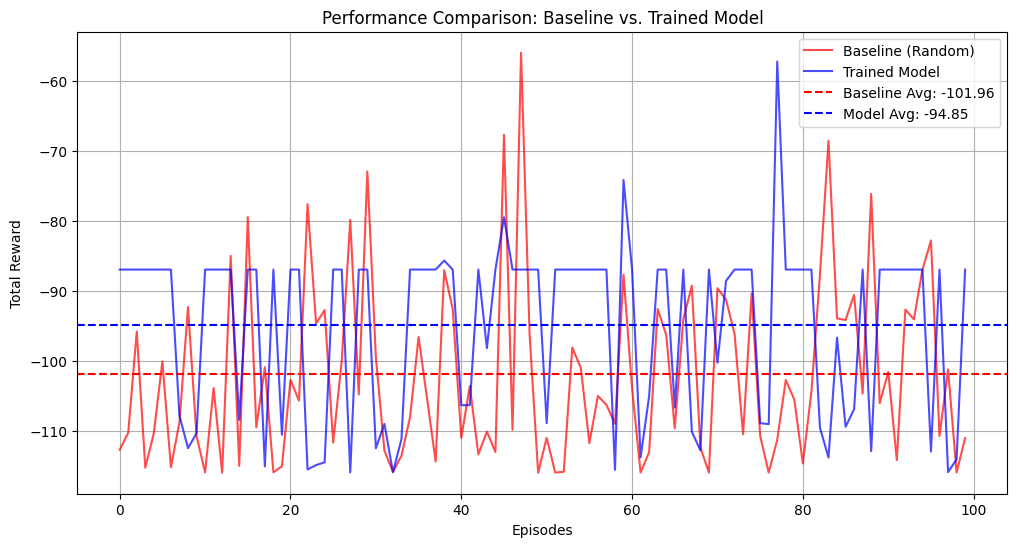

In [ ]:
# line plot gemiddelde score
plt.figure(figsize=(12, 6))
plt.plot(total_score_base, label="Baseline (Random)", color="red", alpha=0.7)
plt.plot(total_rewards, label="Trained Model", color="blue", alpha=0.7)
plt.axhline(y=avg_score, color="red", linestyle="--", label=f"Baseline Avg: {avg_score:.2f}")
plt.axhline(y=np.mean(total_rewards), color="blue", linestyle="--", label=f"Model Avg: {np.mean(total_rewards):.2f}")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Performance Comparison: Baseline vs. Trained Model")
plt.legend()
plt.grid()
plt.show()

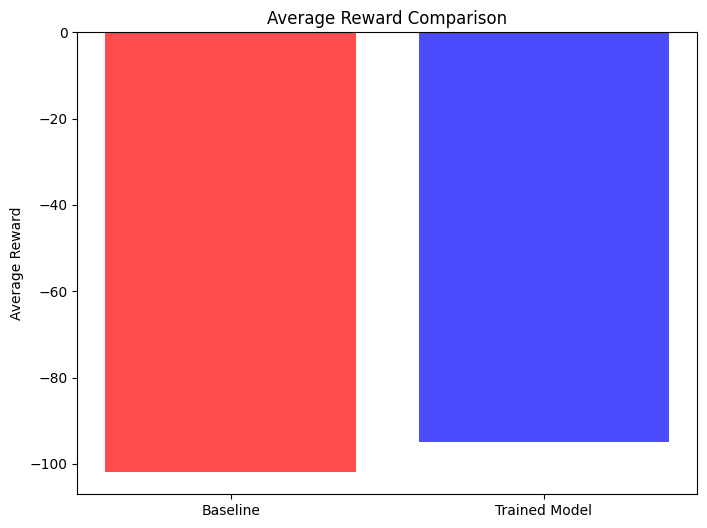

In [ ]:
# Bar chart voor de gemiddelde rewards
labels = ["Baseline", "Trained Model"]
averages = [avg_score, np.mean(total_rewards)]

plt.figure(figsize=(8, 6))
plt.bar(labels, averages, color=["red", "blue"], alpha=0.7)
plt.ylabel("Average Reward")
plt.title("Average Reward Comparison")
plt.show()


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H5: Beschrijf je Werk (Rapporteren) </strong></h2>
</div>

<a name='5.1'></a>
<h3>&sect;5.1: Probleemstelling</h3>

<a name='5.2'></a>
<h3>&sect;5.2: Methodologie</h3>

<a name='5.3'></a>
<h3>&sect;5.3: Resultaten</h3>

<a name='5.4'></a>
<h3>&sect;5.4: Reflectie</h3>


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H6: Literatuurlijst </strong></h2>
</div>


---
<div style="background-color:LightBlue; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> H7: Beoordelingscriteria </strong></h2>
</div>

| **Criteria**                | **Level 4 (5p)**                                                                                                                                                       | **Level 3 (3p)**                                                                                                                                                        | **Level 2 (2p)**                                                                                                                                                       | **Level 1 (0p)**                                                                                                      |
|----------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------|
| **Use-case kiezen**        | De gekozen use-case is creatief, de toepassing is realistisch met duidelijke meerwaarde van RL. Overtuigende motivatie voor RL wordt gegeven.                          | De use-case is creatief en geschikt voor RL en het probleem is goed gedefinieerd, maar de argumentatie is beperkt of vergelijkt de RL benadering niet met andere benaderingen. | De use-case is praktisch maar weinig innovatief, of er wordt beperkte analyse van de meerwaarde van RL.                          | Triviale of irrelevante use-case, die niet geschikt is voor RL. Weinig of geen argumentatie gegeven.                 |
| **Begrip van RL**          | Er wordt een uitgebreide uitleg gegeven van het gekozen RL-algoritme.                                                                                                 | Er is sprake van een basiskennis van het RL-algoritme, maar de uitleg is beperkt of niet gedetailleerd genoeg.                                                         | Oppervlakkige uitleg (bv. de agent leert een hogere reward te krijgen) zonder verdere uitwerking. Kleine fouten in de uitleg.    | Volledig verkeerde, onduidelijke of ontbrekende uitleg.                                                              |
| **Implementatie**          | De Python-implementatie werkt volledig zoals verwacht. De agent leert op een slimme en efficiënte manier door de omgeving te navigeren. De simulatie is 100% reproduceerbaar en toont elke keer de verwachte resultaten. | De Python-implementatie werkt voor het grootste gedeelte van de simulatie, maar faalt in bepaalde scenario's of de agent vertoont af en toe onverwacht gedrag, of de simulatie is niet 100% reproduceerbaar. | De Python-implementatie is rommelig en presteert niet zoals verwacht. De agent faalt vaak of vertoont voor het grootste deel onverwacht gedrag, of de simulatie is bijna nooit reproduceerbaar. | De Python-implementatie werkt nauwelijks of helemaal niet.                                                           |
| **Validatie en vergelijking** | De simulatie wordt getest met realistische scenario's en de prestaties worden grondig geanalyseerd. De resultaten van deze analyse worden duidelijk gevisualiseerd. | Er zijn een behoorlijk aantal tests uitgevoerd, maar de testcases zouden uitgebreider kunnen zijn en de analyse van de resultaten zou diepgaander kunnen zijn.           | Er is een zeer beperkt aantal testen uitgevoerd of de resultaten zijn niet op een bevredigend niveau geanalyseerd en gevisualiseerd. | Er is nauwelijks tot geen testing gedaan.                                                                           |
| **Rapporteren**            | Het rapport is helder en goed gestructureerd. De methodologie is goed uitgelegd.                                                                                      | Het rapport is bevredigend, maar het is niet goed gestructureerd en uitgelegd.                                                                                          | Het rapport is rommelig en er ontbreken belangrijke details.                                                                      | Het rapport is onbevredigend, onjuist of afwezig.                                                                    |
